In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from typing import List, Tuple

In [ ]:
synthetic_data_path = os.path.join(os.path.expanduser('~'), 'data', 'synthetic_data')
os.makedirs(synthetic_data_path, exist_ok=True)

In [ ]:
def generate_ts(periods : int = 60*24*7, 
                start_date : str = '2022-01-01 00:00',
                index_offset : int = 0,
                hourly_factors : List[float] = None,
                hourly_initial_phase : List[float] = None,
                daily_factor : float = 1,
                daily_init_phase : float = 0,
                weekly_factor : float = 1,     
                weekly_init_phase : float = 0,  
                noise_sd : float = 1,
                ts_offset : float = 0,
                trend : float = 0,
               ) -> pd.DataFrame:
    
    
    # Initialization of default lists 
    hourly_factors = hourly_factors or [1]*7
    hourly_phase = hourly_initial_phase or [0]*7
    
    minutes_per_hour = 60
    hourly_freq = (2*np.pi)/(minutes_per_hour)
    daily_freq = (2*np.pi)/(minutes_per_hour*24)
    weekly_freq = (2*np.pi)/(minutes_per_hour*24*7)

    index = pd.date_range(start=start_date, periods=periods, 
                          freq='1min', name='Timestamp')
    x = np.arange(index_offset, index_offset + len(index))
    df = pd.DataFrame(index=index)
    
    hourly_groups = [1, 2, 3, 4, 6, 8, 12]
    for n, f, init_phase in zip(hourly_groups, hourly_factors, hourly_phase):
        df[f'{n} hours component'] = f * np.sin(((1/n) * hourly_freq * x) + init_phase)

    # df['Hourly component'] = sum([y for y, *_ in h.values() if y.any()])
    df['Hourly component'] = df.sum(axis=1)
    df['Daily component']  = daily_factor * np.sin((daily_freq * x) + daily_init_phase)
    df['Weekly component'] = weekly_factor * np.sin((weekly_freq * x) + weekly_init_phase)
    df['Noise'] = np.random.normal(scale=noise_sd, size=len(x))
    
    df['Seasonal time series'] = df['Hourly component'] \
                                 + df['Daily component'] \
                                 + df['Weekly component'] \
                                 + ts_offset
    
    df['Seasonal time series w/ noise'] = df['Seasonal time series'] + df['Noise']
    
    if trend:
        df['Seasonal time series w/ noise and trend'] = df['Seasonal time series w/ noise'] + trend * x
    
    return df

In [ ]:
def plot_ts_components(df : pd.DataFrame,
                       resampling_freq : str = None,
                       figsize : Tuple[float,float] = (20,10),
                       title : str = None
                      ) -> None : 
    
    fig, axes = plt.subplots(4,1,figsize=figsize, sharex=True)
    
    h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]
    all_colors = ['blue','orange','green','red','purple','brown','gray']  # f'tab:{c}'
    
    df.iloc[:,h_index].plot(ax=axes[0], color=[f'tab:{all_colors[i]}' for i in h_index])
            
    df.iloc[:,7:10].plot(ax=axes[1], color=['yellowgreen', 'mediumseagreen', 'gold'])
    df.iloc[:,11].plot(ax=axes[2], color='skyblue')
    if resampling_freq:
        ts = df.iloc[:,-1].resample(resampling_freq).mean()
        ts = ts.rename(f'Resampled time series w/ noise [resampling_freq:{resampling_freq}]')
        ts.plot(ax=axes[3], color='mediumvioletred')
    else:
        df.iloc[:,-1].plot(ax=axes[3], color='mediumvioletred')

    for ax in axes:
        ax.grid(which='both', axis='x')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width, .8*box.height])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
                  fancybox=True, shadow=True, ncol=7)
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9, hspace=0.4)
    plt.show()

## Synthetic Data - Clusters

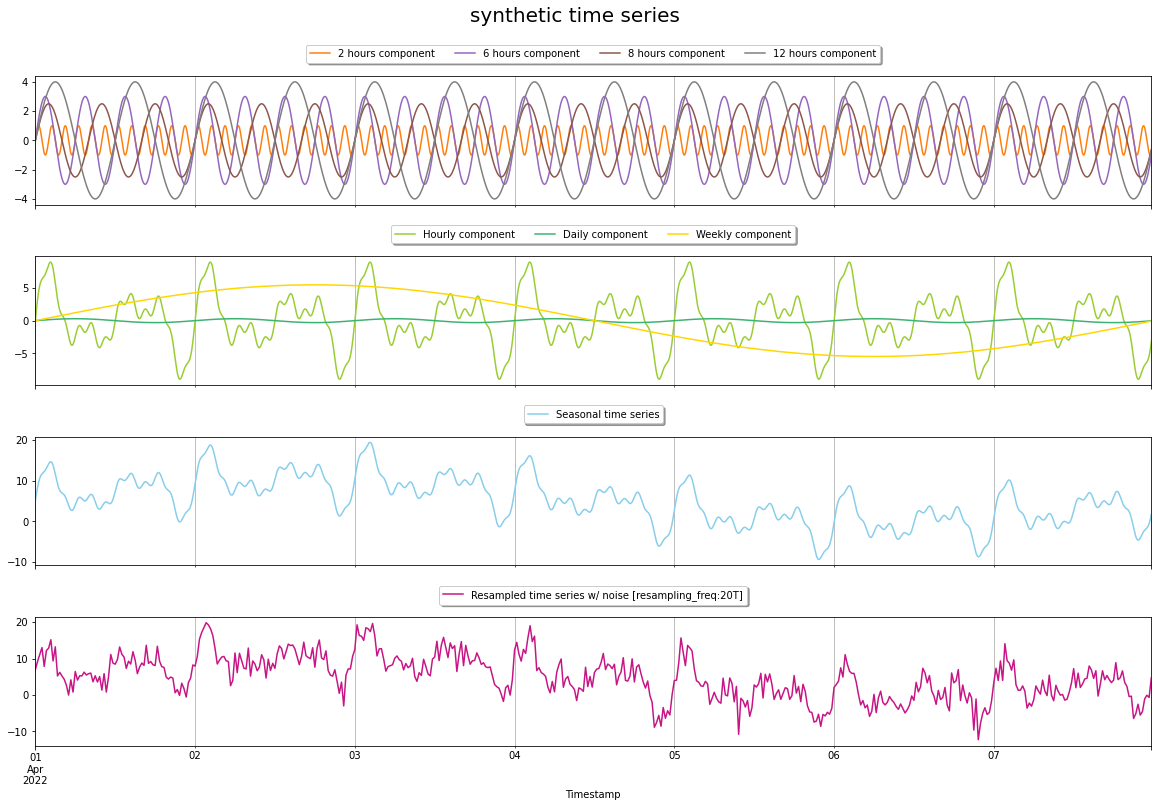

In [ ]:
df = generate_ts(periods=60*24*7, start_date='2022-04-01 00:00', index_offset=0,
                  hourly_factors=[0, 1, 0, 0, 3, 2.5, 4], daily_factor=0.3,
                  weekly_factor=5.5, noise_sd=10, ts_offset=5)
plot_ts_components(df, figsize=(20,12), title='synthetic time series', 
                   resampling_freq='20T')

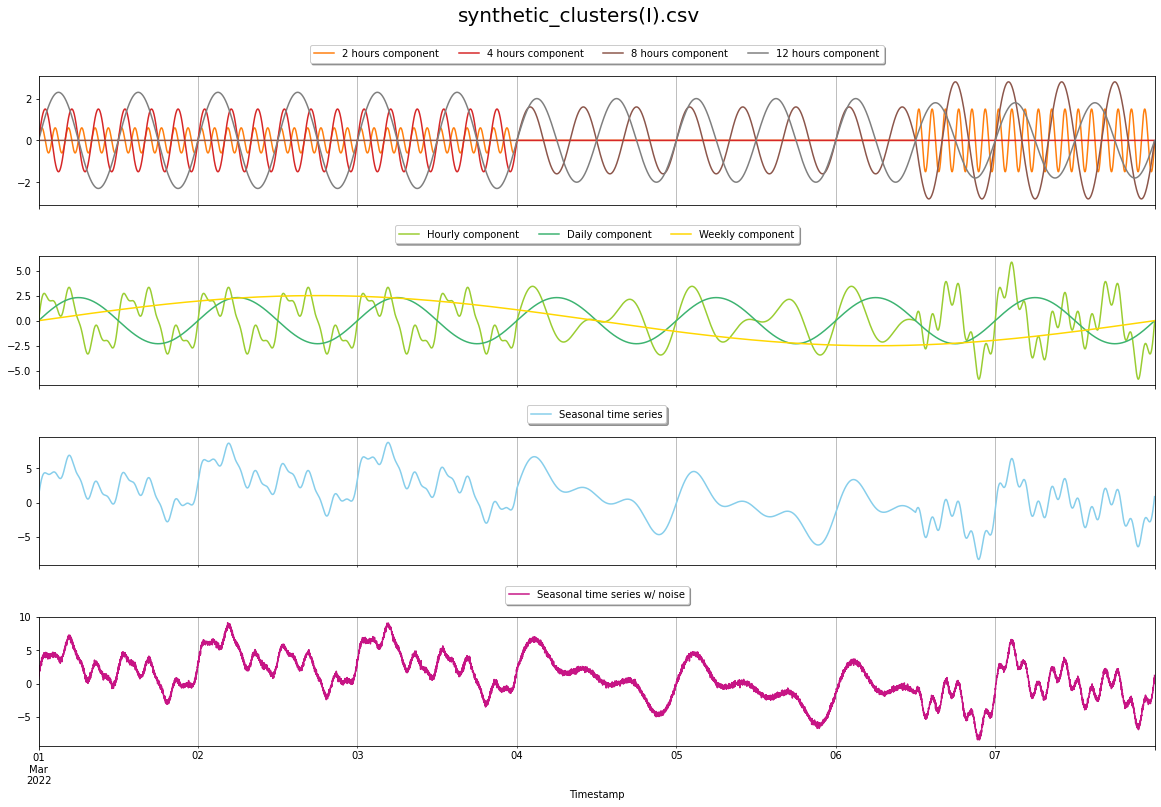

10080

In [ ]:
df1 = generate_ts(periods=60*24*3, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0.6, 0, 1.5, 0, 0, 2.3], daily_factor=2.3, 
                  weekly_factor=2.5, noise_sd=0.2, ts_offset=1)

df2 = generate_ts(periods=60*24*2.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0, 0, 0, 1.6, 2], daily_factor=2.3,
                  weekly_factor=2.5, noise_sd=0.2, ts_offset=1)

df3 = generate_ts(periods=60*24*1.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1.5, 0, 0, 0, 2.8, 1.8], daily_factor=2.3, 
                  weekly_factor=2.5, noise_sd=0.2, ts_offset=1)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_clusters(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
#df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

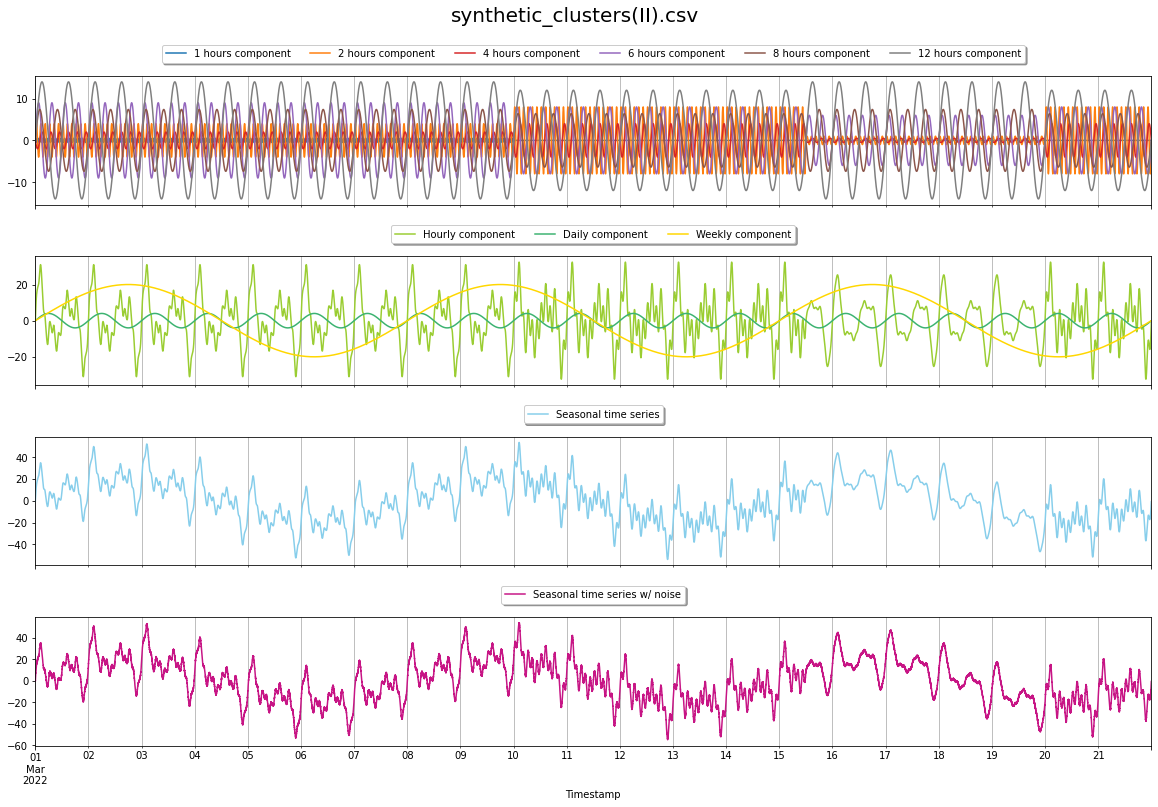

30240

In [ ]:
df1 = generate_ts(periods=60*24*9, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0.5, 4, 0, -2, 9, 7.4, 14], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df2 = generate_ts(periods=60*24*5.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 8, 0, -4, 8, 6.4, 12], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df3 = generate_ts(periods=60*24*4.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1, 0, -0.5, 6, 7.4, 14], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df4 = generate_ts(periods=60*24*2, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 8, 0, -4, 8, 6.4, 12], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df = pd.concat([df1,df2,df3,df4])
time_series_name = 'synthetic_clusters(II).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

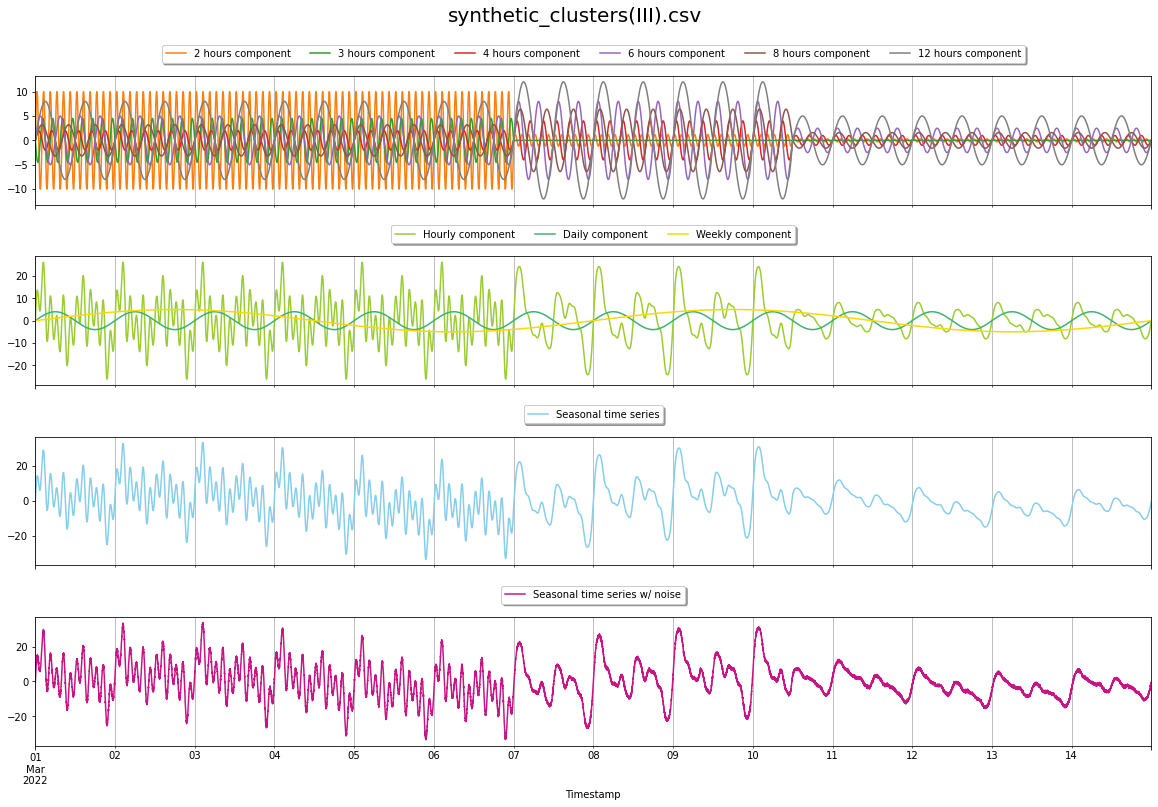

20160

In [ ]:
df1 = generate_ts(periods=60*24*6, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 10, -4.5, 2, 5, 3.2, 8], 
                  daily_factor=4, weekly_factor=5, noise_sd=0.4)

df2 = generate_ts(periods=60*24*3.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1.2, 0, 4, 8, 6.4, 12], 
                  daily_factor=4, weekly_factor=5, noise_sd=0.4)

df3 = generate_ts(periods=60*24*4.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0.3, 0, 1, 2.5, 1.6, 5], 
                  daily_factor=4, weekly_factor=5, noise_sd=0.4)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_clusters(III).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

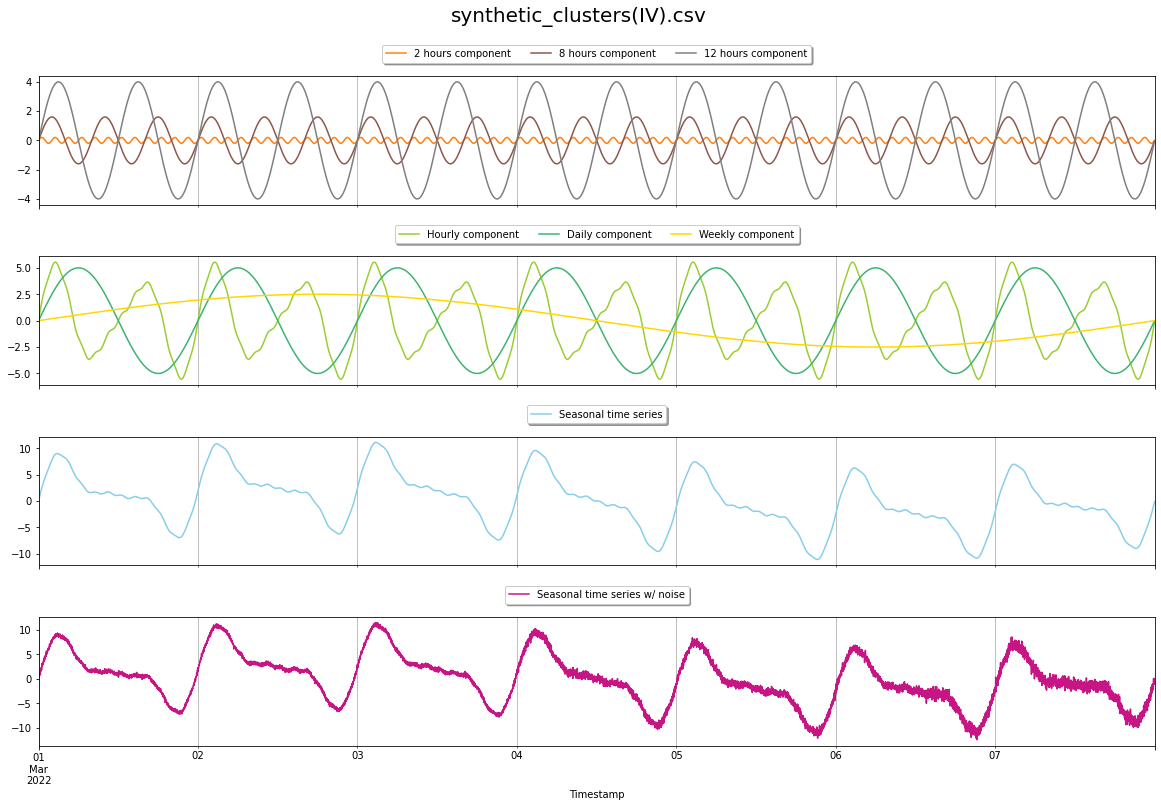

10080

In [ ]:
df1 = generate_ts(periods=60*24*3, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0.2, 0, 0, 0, 1.6, 4], 
                  daily_factor=5, weekly_factor=2.5, noise_sd=0.2)

df2 = generate_ts(periods=60*24*2.5, index_offset=len(df1), 
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0.2, 0, 0, 0, 1.6, 4], 
                  daily_factor=5, weekly_factor=2.5, noise_sd=0.4)

df3 = generate_ts(periods=60*24*1.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()),
                  hourly_factors=[0, 0.2, 0, 0, 0, 1.6, 4], 
                  daily_factor=5, weekly_factor=2.5, noise_sd=0.6)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_clusters(IV).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

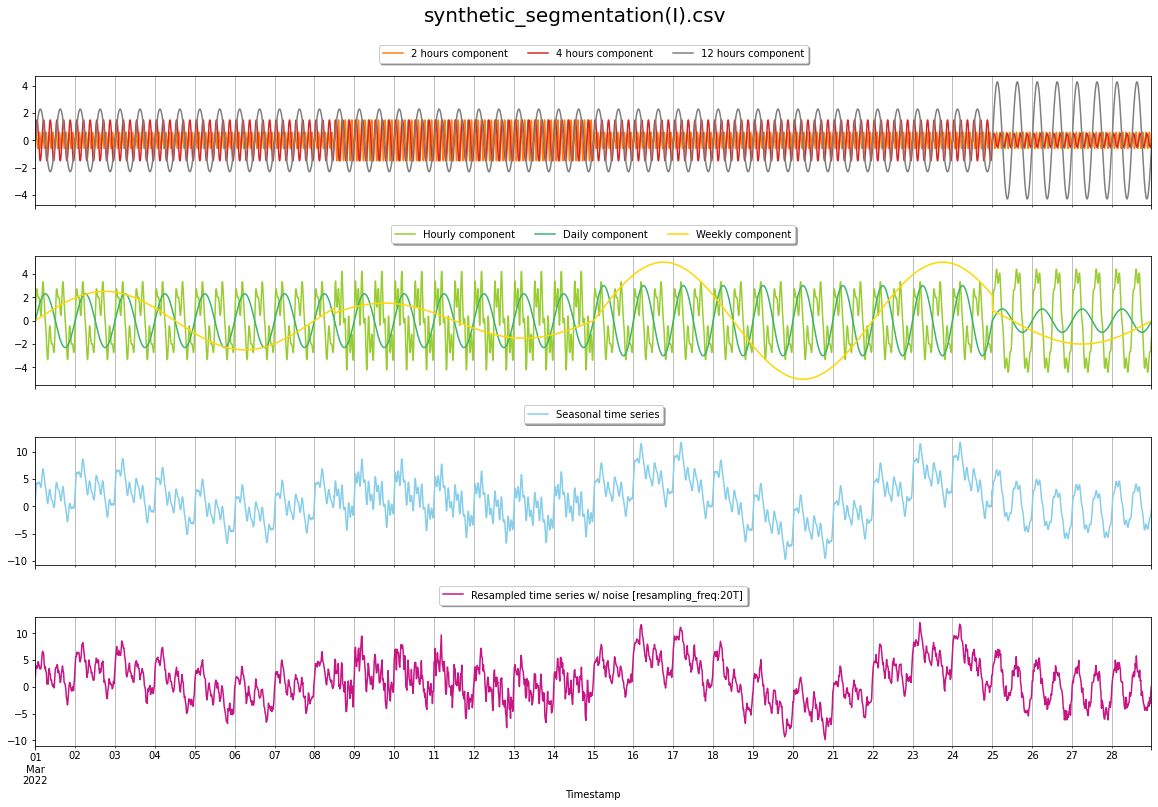

40320

In [ ]:
df1 = generate_ts(periods=60*24*7.5, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0.6, 0, 1.5, 0, 0, 2.3], daily_factor=2.3, 
                  weekly_factor=2.5, noise_sd=2, ts_offset=1)

df2 = generate_ts(periods=60*24*6.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1.5, 0, 1.5, 0, 0, 2.3], daily_factor=2.3,
                  weekly_factor=1.5, noise_sd=4, ts_offset=1)

df3 = generate_ts(periods=60*24*10, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0.6, 0, 1.5, 0, 0, 2.3], daily_factor=3, 
                  weekly_factor=5, noise_sd=2, ts_offset=1)

df4 = generate_ts(periods=60*24*4, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0.6, 0, 0.5, 0, 0, 4.3], daily_factor=1, 
                  weekly_factor=2, noise_sd=3, ts_offset=1)

df = pd.concat([df1,df2,df3,df4])
time_series_name = 'synthetic_segmentation(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='20T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

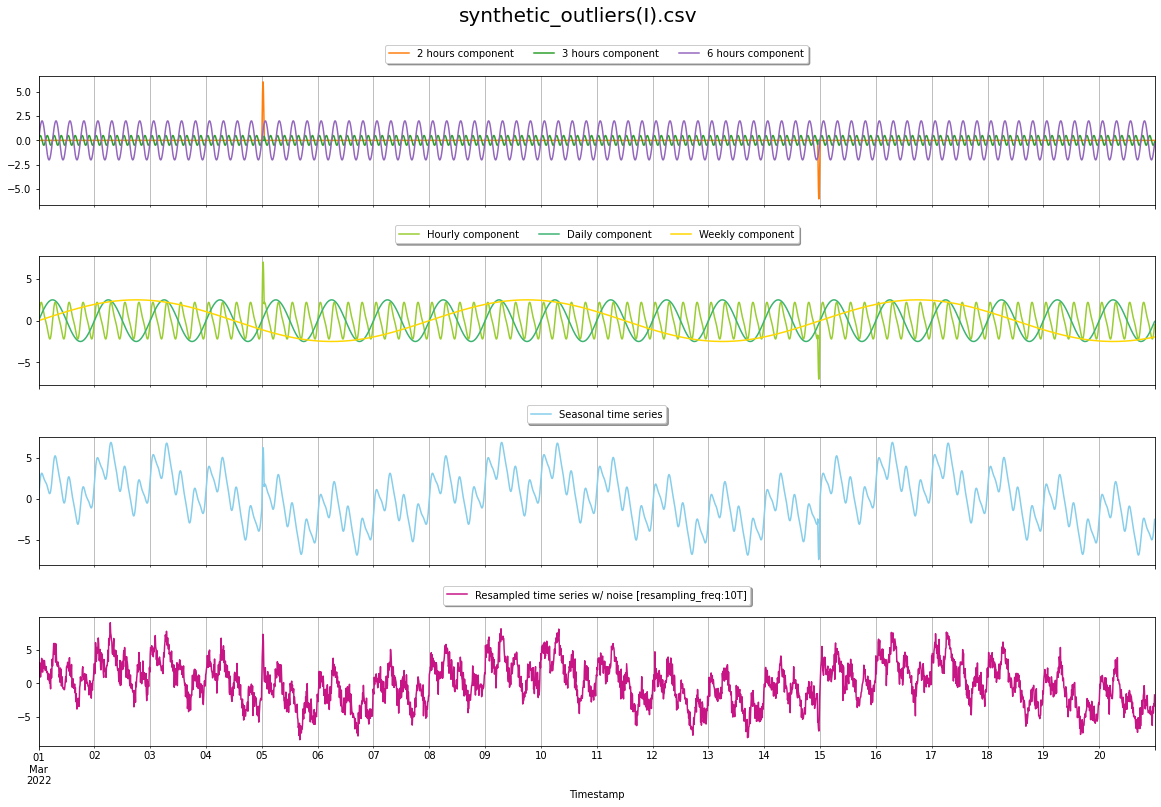

28800

In [ ]:
sd = 3
df1 = generate_ts(periods=60*24*4, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 6, 0, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*24*10-120, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df4 = generate_ts(periods=60, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 6, 0, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
                  start_date=str(df4.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3,df4,df5])
time_series_name = 'synthetic_outliers(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='10T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

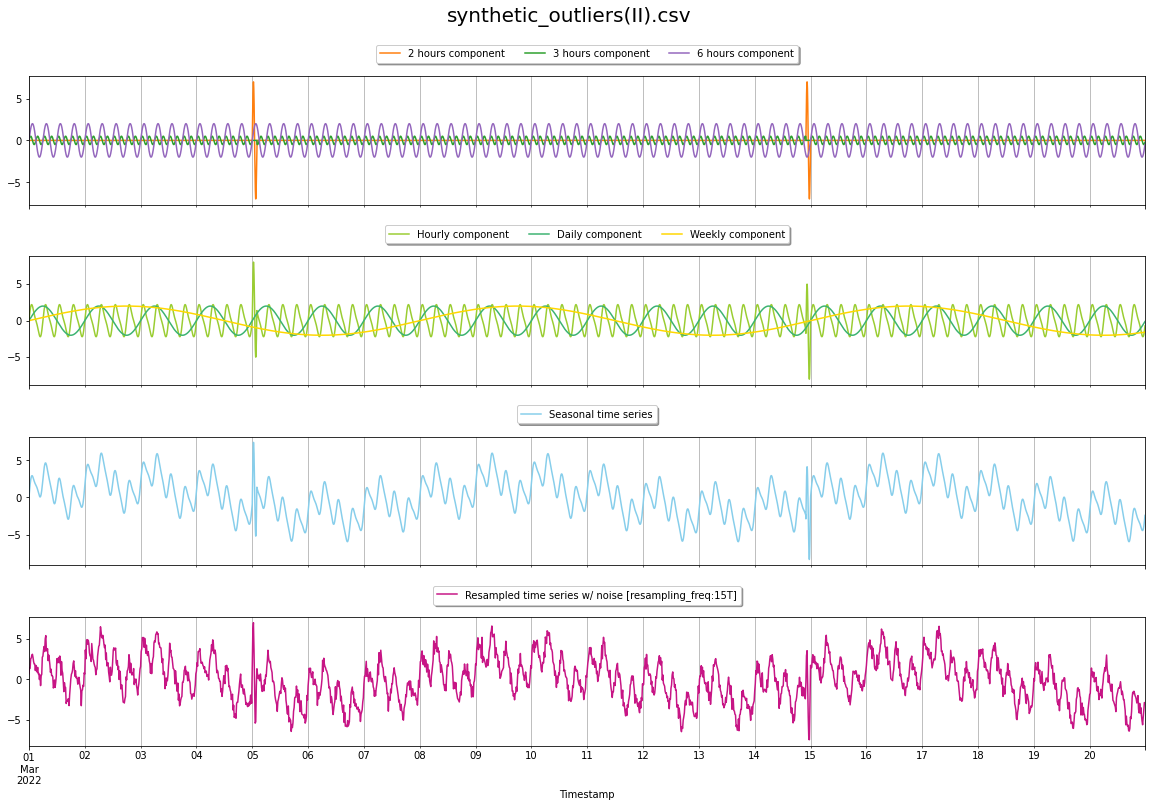

28800

In [ ]:
sd = 2
df1 = generate_ts(periods=60*24*4, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60*2, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*24*10-240, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df4 = generate_ts(periods=60*2, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
                  start_date=str(df4.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3,df4,df5])
time_series_name = 'synthetic_outliers(II).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

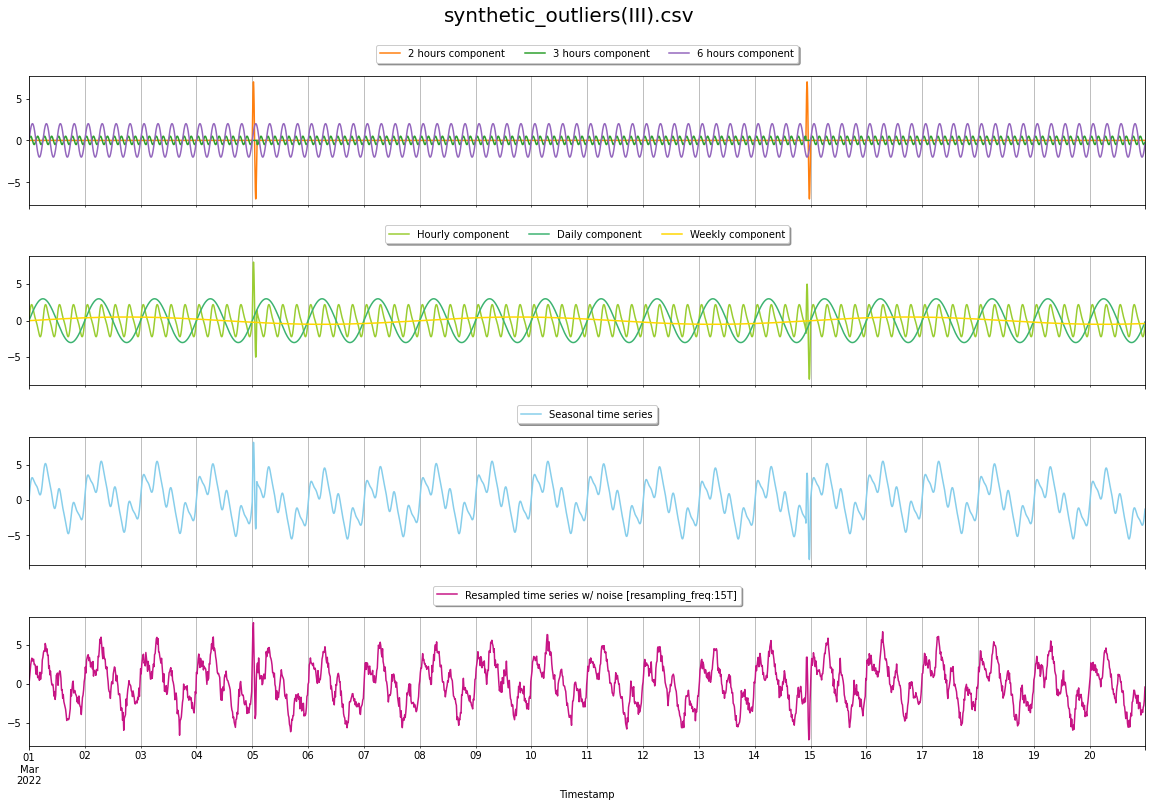

28800

In [ ]:
sd = 2
df1 = generate_ts(periods=60*24*4, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60*2, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*24*10-240, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df4 = generate_ts(periods=60*2, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
                  start_date=str(df4.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3,df4,df5])
time_series_name = 'synthetic_outliers(III).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

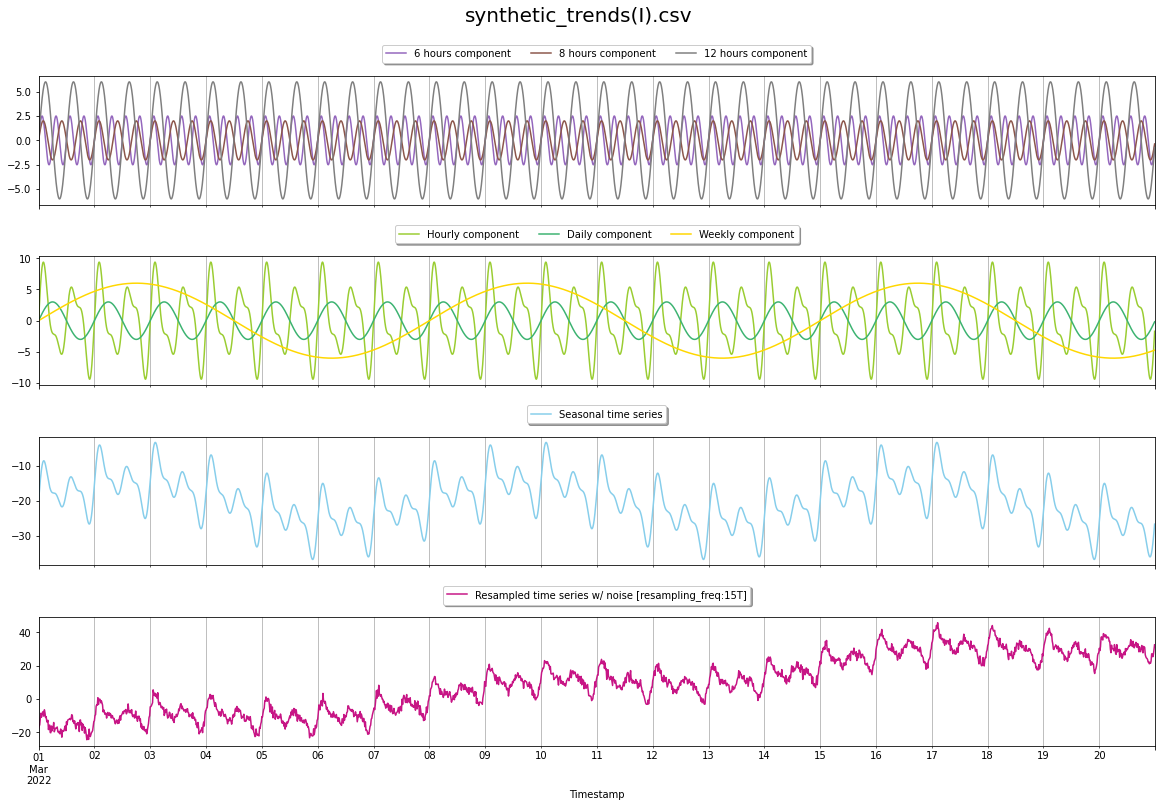

28800

In [ ]:
df1 = generate_ts(periods=60*24*20, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0, 0, 2.5, 2, 6], daily_factor=3, 
                  weekly_factor=6, noise_sd=6, ts_offset=-20, trend=0.002)

df = pd.concat([df1])
time_series_name = 'synthetic_trends(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

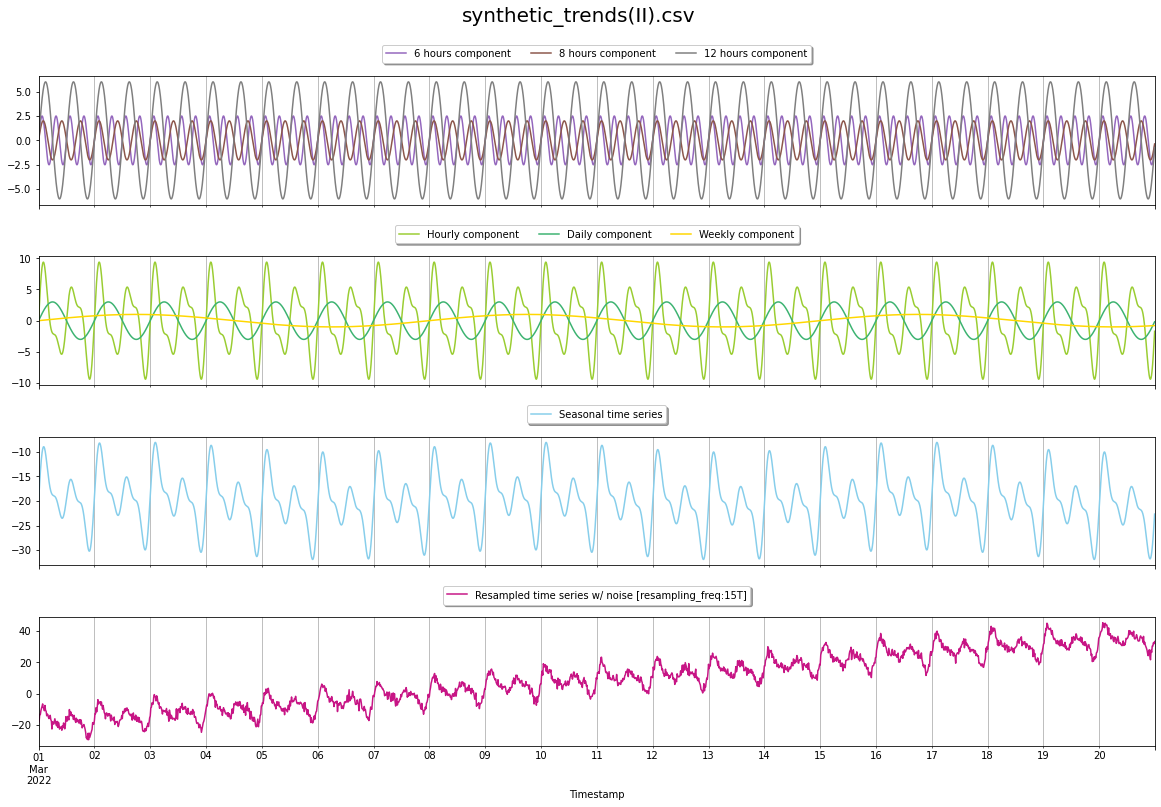

28800

In [ ]:
df1 = generate_ts(periods=60*24*20, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0, 0, 2.5, 2, 6], daily_factor=3, 
                  weekly_factor=1, noise_sd=6, ts_offset=-20, trend=0.002)

df = pd.concat([df1])
time_series_name = 'synthetic_trends(II).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

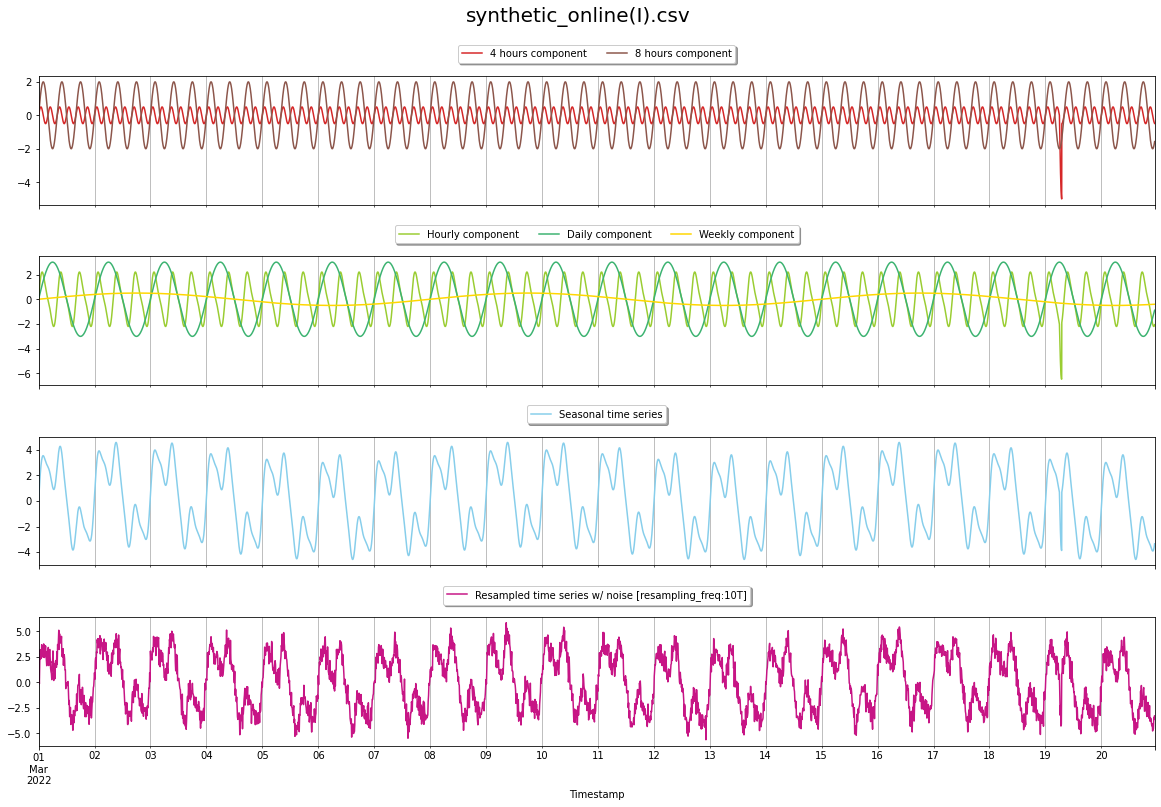

28740

In [ ]:
sd = 2
df1 = generate_ts(periods=60*24*18+60*6, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0, 0.5, 0, 2, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60*1, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0, 5, 0, 2, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*40, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0, 0.5, 0, 2, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

# df4 = generate_ts(periods=60*2, index_offset=len(df1)+len(df2)+len(df3),
#                   start_date=str(df3.index[-1] + pd.offsets.Minute()), 
#                   hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=3, 
#                   weekly_factor=0.5, noise_sd=sd, ts_offset=0)

# df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
#                   start_date=str(df4.index[-1] + pd.offsets.Minute()), 
#                   hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
#                   weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_online(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='10T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)